<h1 align="center">Time Series</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Competitive data science: Predict future sales</a></h3>

In [28]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
# %matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

import gc
import time

from ipywidgets import interact

In [3]:
!ls ../Datasets/Tabular/predict-future-sales

categories.csv	sales_train.csv        shops.csv
items.csv	sample_submission.csv  test.csv


## Daily sales between January 2013 until Octuber 2015.

In [4]:
path = "../Datasets/Tabular/predict-future-sales/"

t = time.time()
df_train = pd.read_csv(path+"sales_train.csv") # Daily sales  Jan 2013 -> Oct 2015
df_shops = pd.read_csv(path+"shops.csv")       # Shops    (60)
df_items = pd.read_csv(path+"items.csv")       # Products  (22170)
df_cats  = pd.read_csv(path+"items.csv") # Product categories (84)
df_test  = pd.read_csv(path+"test.csv", index_col="ID") # predict November 2015
df_sub   = pd.read_csv(path+"sample_submission.csv", index_col="ID")
print(round(time.time() - t,2), "secs")

1.68 secs


In [5]:
df_sub.item_cnt_month = 99
df_sub.head()

,item_cnt_month
ID,
0,99
1,99
2,99
3,99
4,99


In [6]:
df_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [7]:
df_train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# Objetive: sales of November 2015

In [8]:
df_test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# EDA

### Outlier: Sales with a lot of quatities

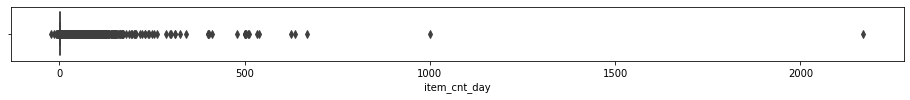

In [9]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df_train.item_cnt_day);

### Outlier: Sales with a expensive items

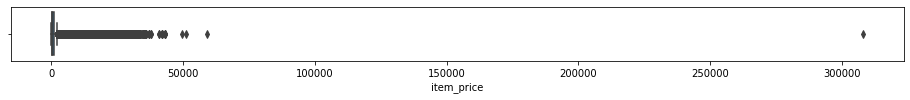

In [10]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df_train.item_price);

### Negative prices -> Refunds

In [11]:
df_train.loc[df_train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [12]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
df_train['item_cnt_day'].sort_values(ascending=False)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
            ...  
59156        -6.0
940092       -6.0
2048519      -9.0
1835454     -16.0
1057907     -22.0
Name: item_cnt_day, Length: 2935849, dtype: float64

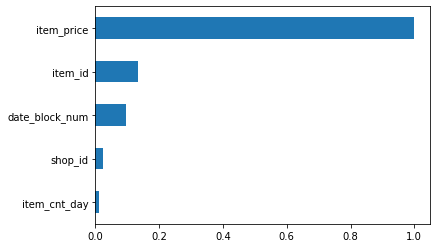

In [14]:
df_train.corr()["item_price"].abs().sort_values().plot.barh();

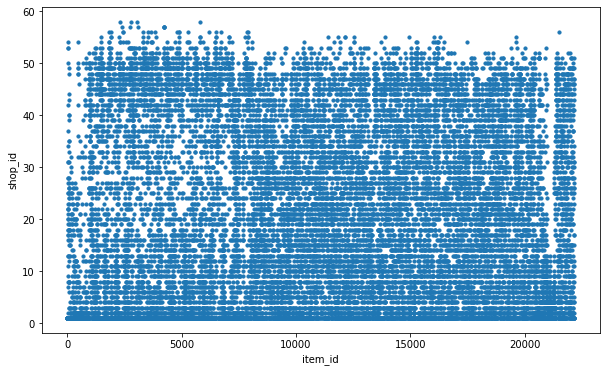

In [15]:
df_train.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10);


<AxesSubplot:xlabel='date_block_num'>

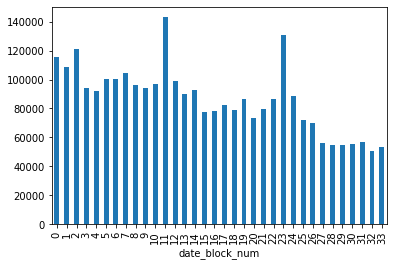

In [18]:
df_train.groupby(["date_block_num"]).size().plot.bar()

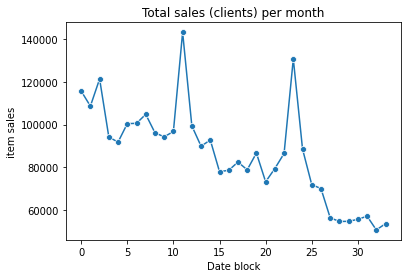

In [19]:
sales_by_month = df_train.groupby('date_block_num').size()

ax = sb.lineplot(data=sales_by_month, marker='.', markersize=12)
_ = ax.set(xlabel = "Date block", ylabel = "item sales", title = "Total sales (clients) per month")

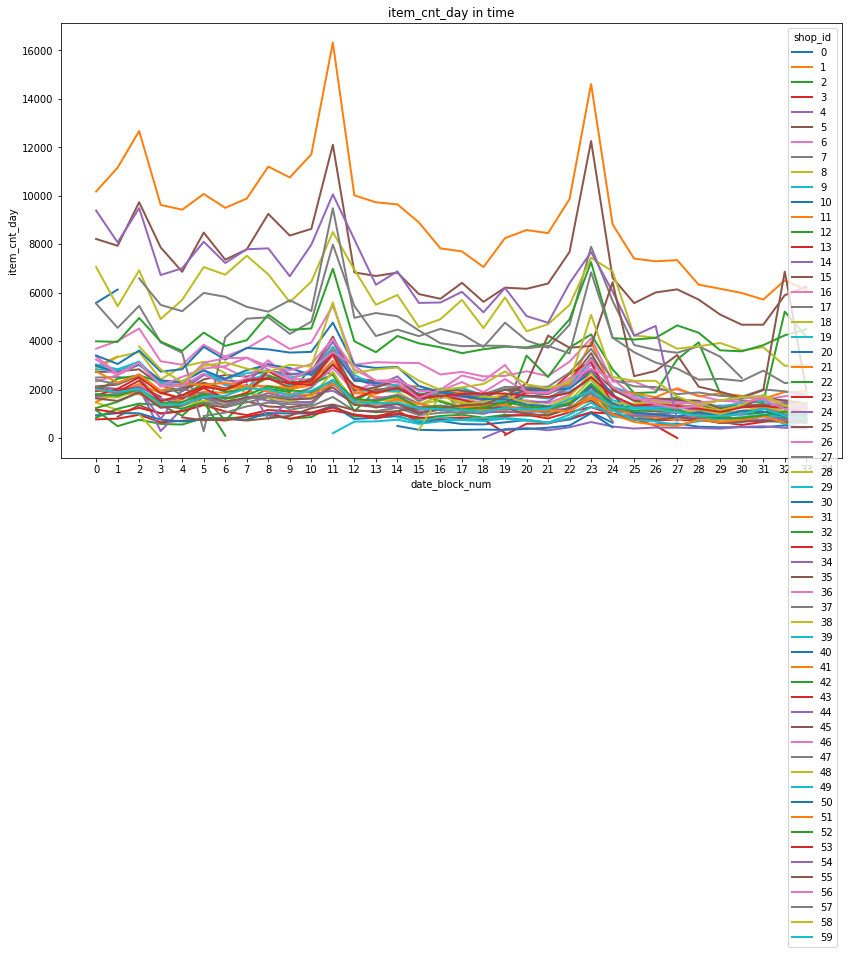

In [22]:
#### PLot the trend chart for the item count - Jan2013 to October 2015
fig = df_train.groupby(['date_block_num' , 'shop_id'])['item_cnt_day'].sum().unstack().plot(
    figsize=(14, 8), linewidth=2)

fig.set_title('item_cnt_day in time')
fig.set_ylabel('item_cnt_day')
plt.xticks(np.arange(0, 35, 1))
plt.show()

In [24]:
# negative prices => REFUNDS
df_train.loc[df_train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [56]:
df_train_1 = df_train[df_train.item_cnt_day < 0]
df_train_1.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [75]:
full = df_train.shape[0]
ref = df_train_1.shape[0]
percentage_refunds = round(ref / full, 5)
print("% of refunds:", percentage_refunds * 100, '%')

% of refunds: 0.251 %


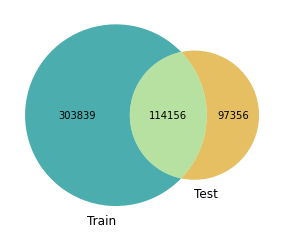

In [41]:
# venn2(subsets = (30, 10, 5), set_labels = ('Group A', 'Group B'), set_colors=('purple', 'skyblue'), alpha = 0.7)

venn2([set((df_train.shop_id.astype(str) + df_train.item_id.astype(str)).unique()),
       set((df_test.shop_id.astype(str)  + df_test.item_id.astype(str)).unique())],
      set_labels = ('Train', 'Test'), set_colors=('darkcyan', 'goldenrod'), alpha = 0.7)
plt.show()

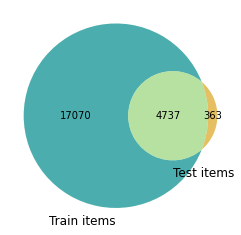

In [49]:
venn2([set(df_train.item_id.unique()), set(df_test.item_id.unique())],
      set_labels = ('Train items', 'Test items'), set_colors=('darkcyan', 'goldenrod'), alpha = 0.7)
plt.show()

## October x November

In [46]:
sep_2015 = df_train[df_train.date_block_num==32]
oct_2015 = df_train[df_train.date_block_num==33]

oct15_item_shop = oct_2015.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()


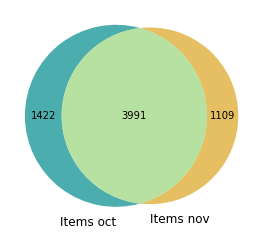

In [50]:
venn2([set(oct_2015.item_id.unique()),
       set(df_test.item_id.unique())],
      set_labels = ('Items oct', 'Items nov'), set_colors=('darkcyan', 'goldenrod'), alpha = 0.7)
plt.show()

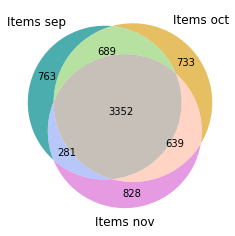

In [54]:
venn3([set(sep_2015.item_id.unique()),
       set(oct_2015.item_id.unique()),
       set(df_test.item_id.unique())],
      set_labels = ('Items sep', 'Items oct', 'Items nov'), set_colors=('darkcyan', 'goldenrod', 'orchid'), alpha = 0.7)
plt.show()

---

## Get only sales of october 2015 

In [ ]:
oct2015 = df_train[df_train.date_block_num==33]
oct2015

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [ ]:
oct2015.shop_id.nunique() # There are 44 of 60 shops on this month

44

In [ ]:
oct2015.item_id.nunique() # There ar 5413 of 22170 items on this month

5413

In [ ]:
oct2015.groupby(["shop_id", "item_id"])[["item_cnt_day"]].agg(["min", "max", "mean", "count", "sum"])

item_cnt_day                     
                         min  max mean count  sum
shop_id item_id                                  
2       31               1.0  1.0  1.0     1  1.0
        486              1.0  1.0  1.0     3  3.0
        787              1.0  1.0  1.0     1  1.0
        794              1.0  1.0  1.0     1  1.0
        968              1.0  1.0  1.0     1  1.0
...                      ...  ...  ...   ...  ...
59      22087            1.0  3.0  2.0     3  6.0
        22088            1.0  1.0  1.0     2  2.0
        22091            1.0  1.0  1.0     1  1.0
        22100            1.0  1.0  1.0     1  1.0
        22102            1.0  1.0  1.0     1  1.0

[31531 rows x 5 columns]

In [ ]:
oct2015_agg = oct2015.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
oct2015_agg

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


In [ ]:
df_test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [ ]:
df_sub.head()

,item_cnt_month
ID,
0,99
1,99
2,99
3,99
4,99


In [ ]:
results = pd.merge(left = df_test,         # Left table for the join
                   right = oct2015_agg, # Right table for the join
                   on=["shop_id", "item_id"], # Common keys
                   how='left')          # Type of join

results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,NaN
1,5,5320,NaN
2,5,5233,1.0
3,5,5232,NaN
4,5,5268,NaN


In [ ]:
print("% of missings:", results.item_cnt_day.isna().sum() / len(results) * 100)

% of missings: 86.61064425770309


### Fill missings with ceros

In [ ]:
results.item_cnt_day = results.item_cnt_day.fillna(0)
results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


### Clipping (limit) mins and max values

In [ ]:
results.item_cnt_day = results.item_cnt_day.clip(lower=0, upper=20)
results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


In [ ]:
df_sub["item_cnt_month"] = results["item_cnt_day"]
df_sub.head()

,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [ ]:
# df_sub.to_csv("oct2015_new.csv")

In [ ]:
# !head oct2015_new.csv

ID,item_cnt_month
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
5,1.0
6,2.0
7,0.0
8,0.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32ebab46-e526-42a3-8966-92f4ff6ef571' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>